# Libraries

In [1]:
import cv2 
from matplotlib import pyplot as plt

import torch 
import torch.nn as nn
from torch.autograd import Variable

from darknet import Darknet
from preprocess import prep_image, inp_to_image
from util import *

# Initialize The YOLOv3 Model

In [4]:
# Loading pre-trained YOLOv3 model weights
print("Loading weights.....")
model = Darknet('cfg/yolov3-tiny.cfg')
model.load_weights('yolov3-tiny.weights')
print("Weights successfully loaded")

Loading weights.....
Weights successfully loaded


In [5]:
# Default Parameter for model
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
num_classes = 80
classes = load_classes('data/coco.names')

In [6]:
# Set image height and check the model
model.net_info["height"] = 416
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

In [7]:
#Set the model in evaluation mode
_ = model.eval()

# Functions For Object Detection

In [8]:
# Draw boxes and label on image
def annotate(x, img):
    """ Returns image with rectangle on result"""
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = (33, 255, 33)
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2, color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    return img

In [35]:
# Detect object with YOLOv3 model
def detect(image='./imgs/person.jpg'):
    """ Return image with rectangles and label at detected object """
    prep = prep_image(image, inp_dim)
    im_batch = prep[0]
    orgin_image = prep[1]
    im_dim_list = torch.FloatTensor(prep[2]).repeat(1,2)

    with torch.no_grad():
        prediction = model(Variable(im_batch), False)

    prediction = write_results(prediction, confidence, num_classes, nms = True, nms_conf = nms_thesh)
    output = prediction

    im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())    
    scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)

    output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
    output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2    
    output[:,1:5] /= scaling_factor

    for i in range(output.shape[0]):
        output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
        output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])

    list(map(lambda x: annotate(x, orgin_image), output))

    return orgin_image
    

# Model Testing

In [36]:
# Set image file location
image = './imgs/person.jpg'

In [37]:
# Perform a detection with image
result = detect(image)

In [38]:
# Write to image file
cv2.imwrite('result.jpg', result)

True

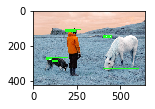

In [44]:
# Show to cell with plt
import random
plt.figure(figsize=(2,2))
_ = plt.imshow(result)

In [14]:
type(plt)

module

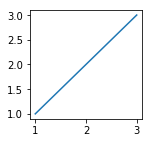

In [43]:
from matplotlib import pyplot as plt
plt.figure(figsize=(2,2))
x = [1,2,3]
plt.plot(x, x)
plt.show()